# **Customer Churn Prediction in the Telecom Industry Using Big Data and Machine Learning**

Using machine learning tools, this project seeks to forecast customer attrition in the telecom sector. Customer churn, sometimes called customer attrition, is the process by which consumers abandon a service provider.

**Step 1: Install Libraries**

In [28]:
!pip install pyspark matplotlib seaborn pandas scikit-learn

**Step 2: Initialize SparkSession**

In [29]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("TelcoChurnLocal") \
    .getOrCreate()

**Step 3: Initializing SparkSession with Local configuration**

In [30]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("TelcoChurnLocal") \
    .master("local[*]") \
    .config("spark.hadoop.fs.defaultFS", "file:///") \
    .getOrCreate()

**Step 4: Stop SparkSession**

In [31]:
spark.stop()

**Step 5: Restart SparkSession and Load Data**


In [32]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("TelcoChurnLocal") \
    .master("local[*]") \
    .config("spark.hadoop.fs.defaultFS", "file:///") \
    .getOrCreate()

**Step 6: Data Preprocessing- Handling Missing Values and Type Casting**

In [33]:
df = spark.read.csv("WA_Fn-UseC_-Telco-Customer-Churn.csv", header=True, inferSchema=True)
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



In [34]:
from pyspark.sql.functions import col
df = df.withColumn("TotalCharges", col("TotalCharges").cast("float"))
df = df.na.drop(subset=["TotalCharges"])

**Step 7: Feature Encoding Cell**

Prepare the categorical features, including the target variable "Churn"

In [35]:
from pyspark.ml.feature import StringIndexer

# Encode target
df = StringIndexer(inputCol="Churn", outputCol="Churn_idx").fit(df).transform(df)

# Encode all other categorical features (except customerID and Churn)
cat_cols = [c for c, t in df.dtypes if t == "string" and c not in ("customerID", "Churn")]
for c in cat_cols:
    indexer = StringIndexer(inputCol=c, outputCol=c + "_idx")
    df = indexer.fit(df).transform(df)


**Step 8: Feature Assembly**

This code combines selected categorical and numerical columns into a single feature vector using VectorAssembler and creates a new DataFrame df_ml containing the feature vector and the target variable "Churn_idx" for machine learning.

In [11]:
from pyspark.ml.feature import VectorAssembler
feature_cols = [c + "_idx" for c in cat_cols] + ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_ml = assembler.transform(df).select("features", "Churn_idx")

**Step 9: Train-Test Split**

This code performs a random split of the DataFrame df_ml into two parts: a training set and a testing set.

In [12]:
train, test = df_ml.randomSplit([0.8, 0.2], seed=42)

**Step 10: Model Training (Random Forest)**

In [15]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="Churn_idx", featuresCol="features", numTrees=100)
model = rf.fit(train)
predictions = model.transform(test)

**Step 11: Model Evaluation**

In [16]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
# Accuracy & F1
evaluator_multi = MulticlassClassificationEvaluator(labelCol="Churn_idx", predictionCol="prediction")
accuracy = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "accuracy"})
f1_score = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "f1"})
# AUC
evaluator_binary = BinaryClassificationEvaluator(labelCol="Churn_idx", rawPredictionCol="rawPrediction")
auc = evaluator_binary.evaluate(predictions, {evaluator_binary.metricName: "areaUnderROC"})
print(f" Accuracy: {accuracy:.4f}")
print(f" F1 Score: {f1_score:.4f}")
print(f" Area Under ROC (AUC): {auc:.4f}")

 Accuracy: 0.8003
 F1 Score: 0.7862
 Area Under ROC (AUC): 0.8328


**Step 12: Confusion Matrix**

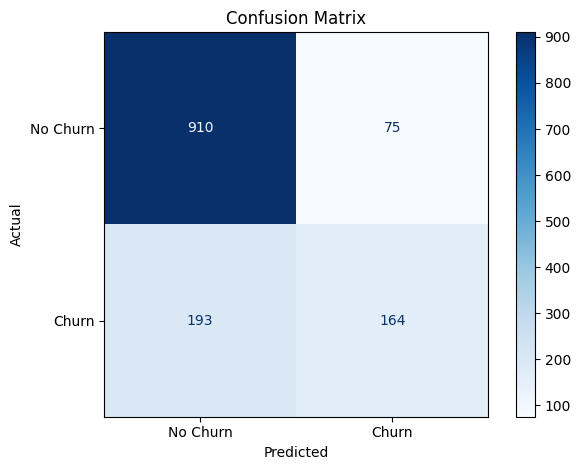

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
y_true = [int(row['Churn_idx']) for row in predictions.select('Churn_idx').collect()]
y_pred = [int(row['prediction']) for row in predictions.select('prediction').collect()]
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Churn", "Churn"])
disp.plot(cmap="Blues", values_format="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

**Step 13: Feature Importance Plot**

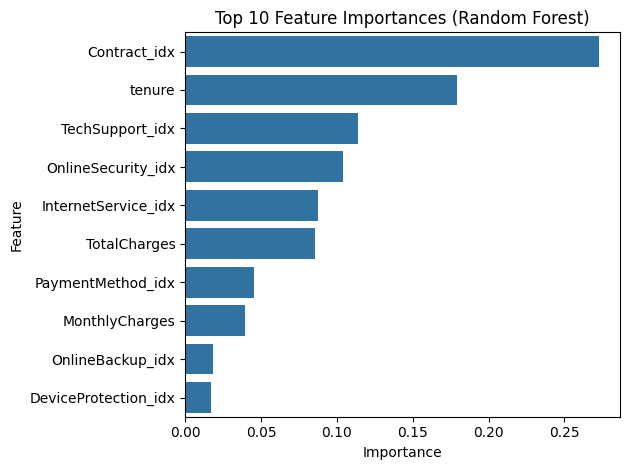

In [18]:
import pandas as pd
import seaborn as sns

feature_importance = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": model.featureImportances.toArray()
}).sort_values(by="Importance", ascending=False).head(10)

sns.barplot(data=feature_importance, x="Importance", y="Feature")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()


**Step 14: Churn Rate by Tenure**

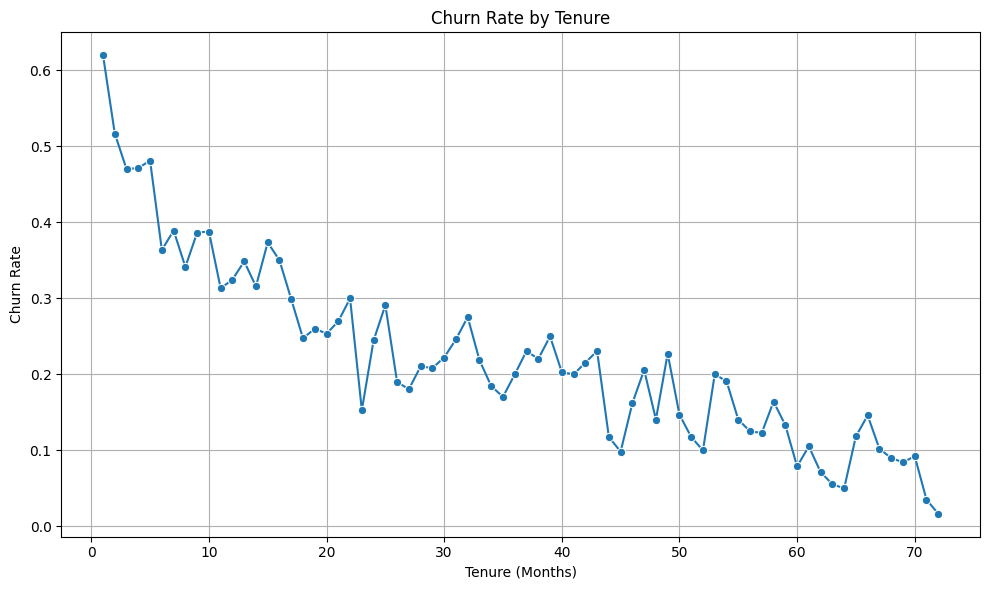

In [19]:
from pyspark.sql.functions import mean

tenure_churn = df.groupBy("tenure").agg(mean("Churn_idx").alias("ChurnRate")).orderBy("tenure")
pdf_tenure_churn = tenure_churn.toPandas()

plt.figure(figsize=(10, 6))
sns.lineplot(data=pdf_tenure_churn, x="tenure", y="ChurnRate", marker="o")
plt.title("Churn Rate by Tenure")
plt.xlabel("Tenure (Months)")
plt.ylabel("Churn Rate")
plt.grid(True)
plt.tight_layout()
plt.show()


**Step 15: Churn Rate by Contract Type**

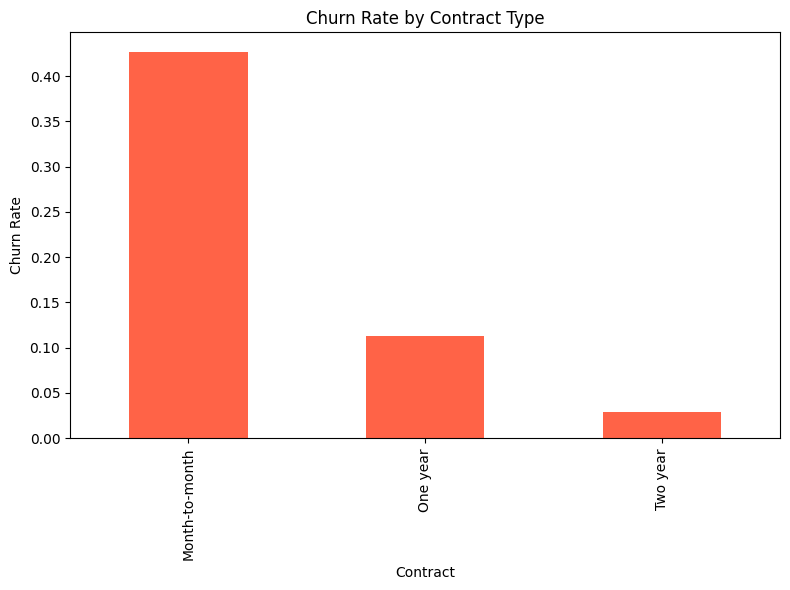

In [20]:
contract_churn = df.groupBy("Contract", "Churn").count()
contract_churn_pdf = contract_churn.groupBy("Contract").pivot("Churn").sum("count").fillna(0).toPandas()

contract_churn_pdf.set_index("Contract", inplace=True)
contract_churn_pdf["ChurnRate"] = contract_churn_pdf["Yes"] / (contract_churn_pdf["Yes"] + contract_churn_pdf["No"])

contract_churn_pdf["ChurnRate"].plot(kind="bar", color="tomato", figsize=(8, 6), title="Churn Rate by Contract Type")
plt.ylabel("Churn Rate")
plt.tight_layout()
plt.show()


**Step 16: Churn Distribution**

<ipython-input-21-bb6e21611637>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=churn_counts, x="Churn", y="count", palette="Set2")


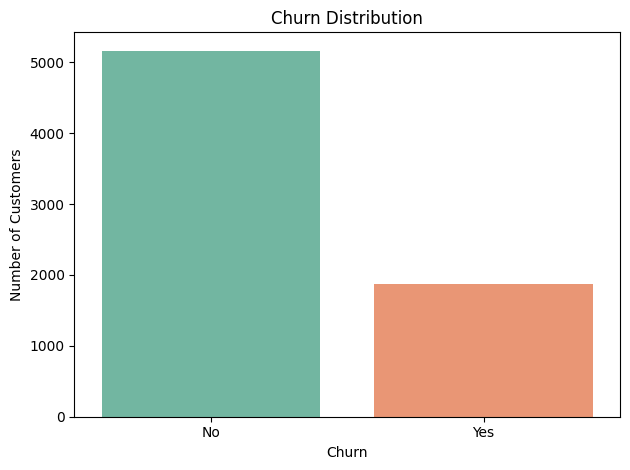

In [21]:
churn_counts = df.groupBy("Churn").count().toPandas()

sns.barplot(data=churn_counts, x="Churn", y="count", palette="Set2")
plt.title("Churn Distribution")
plt.ylabel("Number of Customers")
plt.tight_layout()
plt.show()


**Step 17: Precision-Recall Curve**

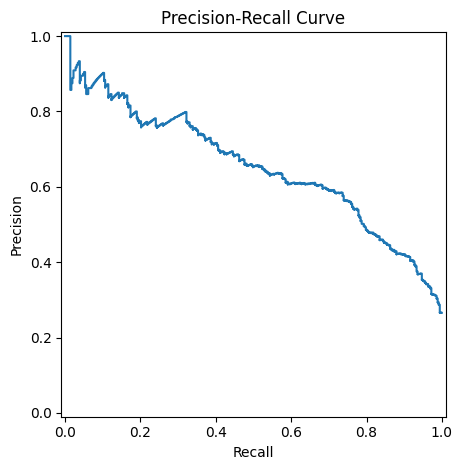

In [22]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

y_scores = [row["probability"][1] for row in predictions.select("probability").collect()]
precision, recall, _ = precision_recall_curve(y_true, y_scores)
PrecisionRecallDisplay(precision=precision, recall=recall).plot()
plt.title("Precision-Recall Curve")
plt.tight_layout()
plt.show()


**Step 18: Monthly Charges Distribution by Churn**

<ipython-input-23-4cbee0b68d4e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_monthly, x="Churn", y="MonthlyCharges", palette="coolwarm")


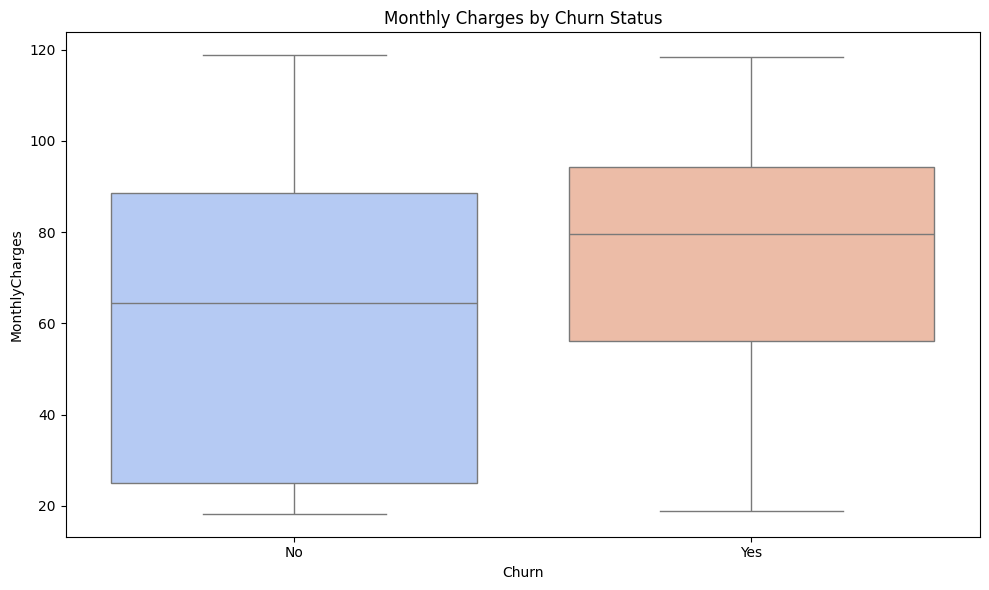

In [23]:
df_monthly = df.select("MonthlyCharges", "Churn").toPandas()
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_monthly, x="Churn", y="MonthlyCharges", palette="coolwarm")
plt.title("Monthly Charges by Churn Status")
plt.tight_layout()
plt.show()


### **Conclusion:**
### This project shows how big data technologies and machine learning may be used to solve the vital business problem of customer turnover in the telecom sector.  Accurate churn prediction enables companies to take proactive steps to enhance customer happiness and lower income loss.